<a href="https://colab.research.google.com/github/aryamtos/augmentation-processing-ddsm/blob/master/MidNet_3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Particionando Dataset

In [ ]:
from PIL import Image
from os import listdir 
from os.path import isdir 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import to_categorical 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def select_image(filename):
    
    image = Image.open(filename) 
    
    image = image.convert('RGB')
    image = image.resize((224,224)) 
    
    return np.asarray(image)  

def load_class(diretorio, classe, imagens, labels):

    for filename in listdir(diretorio):
        
        path = diretorio + filename 
        
        try:
            imagens.append(select_image(path))
            labels.append(classe)
        except:
            print('Erro ao ler imagem{}'.format(path))
    return imagens, labels

def select_data_set(diretorio):
    
    imagens = list()
    labels = list()
    
    for subdir in listdir(diretorio):
        path = diretorio + subdir + '/'
        
        if not isdir(path):
            continue
        imagens, labels = load_class(path, subdir, imagens, labels)
    
    return imagens, labels


nodulos_dataset = '/content/drive/MyDrive/Base/'

imagens,labels = select_data_set(nodulos_dataset)

imagens = np.array(imagens)/255 
labels = np.array(labels) 

lb =LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)


In [ ]:
random_state = 42 
alpha = 1e-5 
epoch = 80

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(imagens, labels, test_size = 0.3, stratify = labels, random_state=random_state)


In [ ]:
len(testY)

646

In [ ]:
len(testX)

646

In [ ]:
len(trainX)

1507

# Parâmetros

*   **Pooldropout_rate** - indica a taxa que vai de 0 a , fração de entrada a dimunuir

*  **lamC e lamF** - Aplica uma "penalidade" de regularização L2 => loss = l2 * reduce_sum(square(x)) ( valor em float)

*   **num_classes** - número de classes
*  **epsilon** - pequeno valor adicionado nos argumentos do BatchNormalization(evita a divisão por zero)

In [ ]:
lamC = 0.00001
lamF = 0.00250
epsilon = 1e-8
pooldropout_rate = 0.1
convdropout_rate = 0.001
num_classes = 2

# Informações sobre a rede 

Rede utilizada para o treinamento


1.   Camadas de convolução 32,64,128,256,512 
2. Camada convolutiva ->  batchnormalization -> maxpooling -> dropout ...

3.   Batchnormalization - normaliza as entradas, mantém a saída média perto de 0 e o desvio padrão próximo a 1 de acordo com a documentação do keras para cada canal sendo normalizado é retornado ( batch - mean(batch))/(var (batch) + epsilon) * gamma + beta. Foram colocados inicializadores para o peso beta

4. Foram utilizados inicializadores de peso para camada responsáveis por definir pesos aleatórios iniciais para as camadas:
    1.   kernel_initializer

MidNet

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
from tensorflow.keras import layers
from tensorflow.python.keras import regularizers
from tensorflow.keras import initializers

In [ ]:
batch_size = 60

epsilon = 1e-8

epochs_per_decay = 5
starting_rate = 0.001
decay_factor = 0.80
staircase = True

# lambdas
lamC = 0.00001
lamF = 0.00250

# use dropout
dropout = True
fcdropout_rate = 0.5
convdropout_rate = 0.001
pooldropout_rate = 0.1


model = tf.keras.Sequential([

  layers.Conv2D(filters=32,
                kernel_size=(3,3),
                strides=(2,2),
                padding='SAME',
                activation=None,
                kernel_initializer=initializers.TruncatedNormal(stddev=5e-2, seed=100),
                kernel_regularizer=regularizers.L2(lamC),
                name='conv1'
                ),
  layers.BatchNormalization(
                            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            name='bn1'),
  layers.ReLU(name='relu1'),

  

  layers.Conv2D(filters=32,
                kernel_size=(3,3),
                strides=(1,1),
                padding='SAME',
                activation=None,
                 kernel_initializer=initializers.TruncatedNormal(stddev=5e-2, seed=1101),
                kernel_regularizer=regularizers.L2(lamC),
                name='conv1.2'),

  layers.BatchNormalization(
    axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            name='bn1.2'
    ),
  layers.ReLU(name='relu1.2'),

  layers.MaxPooling2D(pool_size=(3,3),
                      strides=(2,2),
                      padding='SAME',
                      name='pool1'),

  layers.Dropout(rate=pooldropout_rate, seed=103),

  layers.Conv2D(filters=64,
                kernel_size=(3,3),
                strides=(1,1),
                padding='SAME',
                activation=None,
                 kernel_initializer=initializers.TruncatedNormal(stddev=5e-2, seed=104),
                kernel_regularizer=regularizers.L2(lamC),
                name ='conv2'),
  layers.BatchNormalization(
                axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            name='bn2'),
  layers.ReLU(name='relu2'),

  layers.Conv2D(filters=64,
                kernel_size=(3,3),
                strides=(1,1),
                padding='SAME',
                activation=None,
                 kernel_initializer=initializers.TruncatedNormal(stddev=5e-2, seed=1104),
                kernel_regularizer=regularizers.L2(lamC),
                name='conv2.2'),
  layers.BatchNormalization(
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            name='bn2.2'),

  layers.ReLU(name='relu2.2'),

  layers.MaxPooling2D(pool_size=(2,2),
                      strides=(2,2),
                      padding='SAME',
                      name='pool2'),
  layers.Dropout(rate=pooldropout_rate,seed=106),



  layers.Conv2D(filters=128,
                kernel_size=(3,3),
                strides=(1,1),
                padding='SAME',
                activation=None,
                 kernel_initializer=initializers.TruncatedNormal(stddev=5e-2, seed=1107),
                kernel_regularizer=regularizers.L2(lamC),
                name='conv3.3'),
  layers.BatchNormalization( axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            name='bn3.3'),

  layers.ReLU(name='relu3.3'),
  layers.MaxPooling2D(pool_size=(2,2),
                      strides=(2,2),
                      padding='SAME',
                      name='pool3'),
  layers.Dropout(rate=pooldropout_rate,seed=109),

  layers.Conv2D(filters=256,
                kernel_size=(3,3),
                strides=(1,1),
                padding='SAME',
                activation=None,
                 kernel_initializer=initializers.TruncatedNormal(stddev=5e-2, seed=110),
                kernel_regularizer=regularizers.L2(lamC),
                name='conv4'),
  layers.BatchNormalization(
    axis=-1,
                momentum=0.99,
                epsilon=epsilon,
                center=True,
                scale=True,
                beta_initializer=tf.zeros_initializer(),
                gamma_initializer=tf.ones_initializer(),
                moving_mean_initializer=tf.zeros_initializer(),
                moving_variance_initializer=tf.ones_initializer(),
                name='bn4'),
  layers.ReLU(name='relu4'),
  layers.MaxPooling2D(pool_size=(2,2),
    strides=(2,2),
    padding='SAME',
    name='pool4'),
  layers.Dropout(rate=pooldropout_rate,seed=112),

  layers.Conv2D(filters=512,
                kernel_size=(3,3),
                strides=(1,1),
                padding='SAME',
                activation=None,
                 kernel_initializer=initializers.TruncatedNormal(stddev=5e-2, seed=113),
                kernel_regularizer=regularizers.L2(lamC),
                name='conv5'),
  layers.BatchNormalization( axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            name='bn5'),
  layers.ReLU(name='relu5'),
  layers.MaxPooling2D(pool_size=(2,2),
    strides=(2,2),
    padding='SAME',
    name='pool5'),
  layers.Dropout(rate=pooldropout_rate,seed=115),
  
  layers.Flatten(),
  layers.Dropout(rate=fcdropout_rate,seed=116),
  layers.Dense(512,activation=None,
               kernel_initializer=initializers.VarianceScaling(scale=2, seed=117),
                bias_initializer=initializers.Zeros(),
                kernel_regularizer=regularizers.L2(lamF),
              name='fc1'),
  layers.BatchNormalization(axis=-1,
            momentum=0.9,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            name='bn_fc1'),
  layers.ReLU(name='fc1_2'),
  layers.Dropout(rate=fcdropout_rate,seed=118),

  layers.Dense(num_classes,
              activation="softmax",
               kernel_initializer=initializers.VarianceScaling(scale=1, seed=121),
                bias_initializer=initializers.Zeros(),
                name ="logits")

])

In [ ]:
batch_size = 60

epsilon = 1e-8

epochs_per_decay = 5
starting_rate = 0.001
decay_factor = 0.80
staircase = True

# lambdas
lamC = 0.00001
lamF = 0.00250

# use dropout
dropout = True
fcdropout_rate = 0.5
convdropout_rate = 0.001
pooldropout_rate = 0.1


model = tf.keras.Sequential([

  layers.Conv2D(filters=32,
                kernel_size=(3,3),
                strides=(2,2),
                padding='SAME',
                activation=None,
                kernel_initializer=initializers.TruncatedNormal(stddev=5e-2, seed=100),
                kernel_regularizer=regularizers.L2(lamC),
                name='conv1'
                ),
  layers.BatchNormalization(
                            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            name='bn1'),
  layers.ReLU(name='relu1'),

  layers.MaxPooling2D(pool_size=(3,3),
                      strides=(2,2),
                      padding='SAME',
                      name='pool1'),

  layers.Dropout(rate=pooldropout_rate, seed=103),

  layers.Conv2D(filters=64,
                kernel_size=(3,3),
                strides=(1,1),
                padding='SAME',
                activation=None,
                 kernel_initializer=initializers.TruncatedNormal(stddev=5e-2, seed=104),
                kernel_regularizer=regularizers.L2(lamC),
                name ='conv2'),
  layers.BatchNormalization(
                axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            name='bn2'),
  layers.ReLU(name='relu2'),

  

  layers.MaxPooling2D(pool_size=(2,2),
                      strides=(2,2),
                      padding='SAME',
                      name='pool2'),
  layers.Dropout(rate=pooldropout_rate,seed=106),
  layers.Conv2D(filters=128,
                kernel_size=(3,3),
                strides=(1,1),
                padding='SAME',
                activation=None,
                 kernel_initializer=initializers.TruncatedNormal(stddev=5e-2, seed=1104),
                kernel_regularizer=regularizers.L2(lamC),
                name='conv7.2'),
  layers.BatchNormalization(
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            name='bn7.2'),

  layers.ReLU(name='relu7.2'),

  layers.MaxPooling2D(pool_size=(2,2),
                      strides=(2,2),
                      padding='SAME',
                      name='pool7'),
  layers.Dropout(rate=pooldropout_rate,seed=106),
  layers.Flatten(),
  layers.Dropout(rate=fcdropout_rate,seed=116),
  layers.Dense(128,activation=None,
               kernel_initializer=initializers.VarianceScaling(scale=2, seed=117),
               bias_initializer=initializers.Zeros(),
              kernel_regularizer=regularizers.L2(lamF),
              name='fc1'),
  layers.BatchNormalization(axis=-1,
            momentum=0.9,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            name='bn_fc1'),
  layers.ReLU(name='fc1_2'),
  layers.Dropout(rate=fcdropout_rate,seed=118),

  layers.Dense(num_classes,
              activation="softmax",
               kernel_initializer=initializers.VarianceScaling(scale=1, seed=121),
                bias_initializer=initializers.Zeros(),
                name ="logits")

])

# Callbacks

*ReduceLROnPlateau* - redução da taxa de aprendizagem quando uma métrica para de melhorar, se nenhuma melhoria é vista para uma determinada quantidade de 'períodos de  paciência' a taxa de aprendizagem é reduzida


*   monitor -> quantidade a ser monitorada
*   factor -> fator pelo qual a taxa de aprendizagem será reduzida. (novo_lr = lr * factor

*   patience -> número de épocas sem melhora, após isso a taxa será reduzida
*   min_delta -> limite para definir um novo valor 'ótimo' 


*ModelCheckpoint* - salvar modelo ou pesos


*   filepath -local para salvar o arquivo
*   monitor - a métrica que deve ser monitorada
*   save_best_only - só salva quando o modelo é considerado o 'melhor'
*   mode - nesse caso a decisão de sobrescrever o arquivo salvo atual é feito com base na maximização( max)

*EarlyStopping* - parar treinamento quando o modelo não melhorar mais

*   monitor - quantidade a ser monitorada
*   min_delta - mudança mínia feita na quantidade monitorada
*   patience - número de épocas sem melhora, após isso treinamento interrompe
*   mode - min o treinamento irá parar quando a quantidade diminuir


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint ,TensorBoard,ReduceLROnPlateau, EarlyStopping

NAME = "MiDNet3.0-7"

tensorboard = TensorBoard(log_dir = "/content/drive/MyDrive/{}".format(NAME))


filepath = '/content/drive/MyDrive/MiDNet3.0-7_weights.h5' 
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only = True, mode = 'max')
lr_reduce = ReduceLROnPlateau(monitor='loss', factor=0.1, min_delta=alpha, patience= 5, verbose= 1)

early_stop = EarlyStopping(monitor='val_loss',
min_delta=0.001,
patience=5,
mode='min',
verbose=1)

callbacks = [checkpoint ,lr_reduce,tensorboard]

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint ,TensorBoard,ReduceLROnPlateau, EarlyStopping

NAME = "MiDNet3.0-6"

tensorboard = TensorBoard(log_dir = "/content/drive/MyDrive/{}".format(NAME))


filepath = '/content/drive/MyDrive/MiDNet3.0-6_weights.h5' 
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only = True, mode = 'max')
lr_reduce = ReduceLROnPlateau(monitor='loss', factor=0.1, min_delta=alpha, patience= 5, verbose= 1)

early_stop = EarlyStopping(monitor='val_loss',
min_delta=0.001,
patience=5,
mode='min',
verbose=1)

callbacks = [checkpoint ,lr_reduce,tensorboard]

#  Compilação

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam, Adagrad

Parâmetros opcionais

In [ ]:
opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2 = 0.999)

Acurácia

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Metrica Recall

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=[tf.keras.metrics.Recall()])

Area under the curve - AUC

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=[tf.keras.metrics.AUC()])

In [ ]:
history = model.fit(trainX, trainY, steps_per_epoch=len(trainX)//batch_size, validation_data=(testX, testY), validation_steps= len(testX)//batch_size,callbacks=callbacks, epochs = 250)


Epoch 1/250
24/25 [===========================>..] - ETA: 0s - loss: 0.0767 - accuracy: 0.9993
Epoch 00001: val_loss did not improve from 2.59706
25/25 [==============================] - 2s 80ms/step - loss: 0.0767 - accuracy: 0.9993 - val_loss: 1.7188 - val_accuracy: 0.6734 - lr: 1.0000e-34
Epoch 2/250
24/25 [===========================>..] - ETA: 0s - loss: 0.0797 - accuracy: 0.9980
Epoch 00002: val_loss did not improve from 2.59706
25/25 [==============================] - 2s 68ms/step - loss: 0.0798 - accuracy: 0.9980 - val_loss: 1.7201 - val_accuracy: 0.6703 - lr: 1.0000e-34
Epoch 3/250
24/25 [===========================>..] - ETA: 0s - loss: 0.0799 - accuracy: 0.9986
Epoch 00003: val_loss did not improve from 2.59706
25/25 [==============================] - 2s 66ms/step - loss: 0.0798 - accuracy: 0.9987 - val_loss: 1.7321 - val_accuracy: 0.6687 - lr: 1.0000e-34
Epoch 4/250
24/25 [===========================>..] - ETA: 0s - loss: 0.0769 - accuracy: 1.0000
Epoch 00004: val_loss did 

# Avaliação 

In [ ]:
_, acc = model.evaluate( testX,testY, verbose=0)

In [ ]:
print('> %.4f' % (acc * 100.0))

> 70.3237


In [ ]:
# history da acurácia e do loss
tra_loss_9 = history.history['loss']
tra_acc_9 = history.history['accuracy']
val_loss_9 = history.history['val_loss']
val_acc_9 = history.history['val_accuracy']

# Total do número de epochs 
epochs_9 = range(1, len(tra_acc_9)+1)
end_epoch_9 = len(tra_acc_9)

# Epoch quando alcança o loss mínimo
opt_epoch_9 = val_loss_9.index(min(val_loss_9)) + 1

# Loss e acurácia no dataset de validação
end_val_loss_9 = val_loss_9[-1]
end_val_acc_9 = val_acc_9[-1]
opt_val_loss_9 = val_loss_9[opt_epoch_9-1]
opt_val_acc_9 = val_acc_9[opt_epoch_9-1]

In [ ]:
print("Epoch [end]: %d" % end_epoch_9)
print("Epoch [opt]: %d" % opt_epoch_9)
print("Valid accuracy [end]: %.4f" % end_val_acc_9)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_9)

print("Valid loss [end]: %.4f" % end_val_loss_9)
print("Valid loss [opt]: %.4f" % opt_val_loss_9)

Epoch [end]: 80
Epoch [opt]: 38
Valid accuracy [end]: 0.7032
Valid accuracy [opt]: 0.7176
Valid loss [end]: 0.9319
Valid loss [opt]: 0.8644


In [ ]:
test_loss_0, test_acc_0 = model.evaluate(testX, testY, verbose=False)


In [ ]:
print("Test accuracy [end]:  %.4f" % test_acc_0)

Test accuracy [end]:  0.7032


In [ ]:
print("Test loss [end]:  %.4f" % test_loss_0)

Test loss [end]:  0.9319


<h1>Gráficos</h1>

In [ ]:
import matplotlib.pyplot as plt

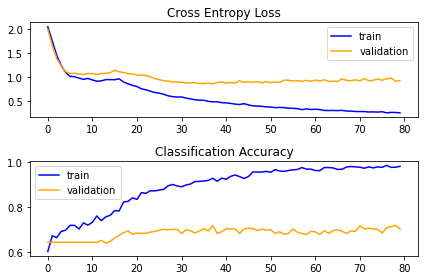

In [ ]:
ax1 = plt.subplot(211)
plt.title('Cross Entropy Loss')
ax1.plot(history.history['loss'], color='blue', label='train')
ax1.plot(history.history['val_loss'], color='orange', label='validation')
ax1.legend()
    # plot accuracy
ax2 = plt.subplot(212)
plt.title('Classification Accuracy')
ax2.plot(history.history['accuracy'], color='blue', label='train')
ax2.plot(history.history['val_accuracy'], color='orange', label='validation')
ax2.legend()
plt.tight_layout()

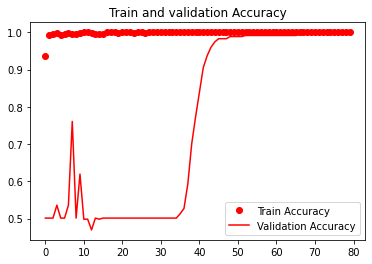

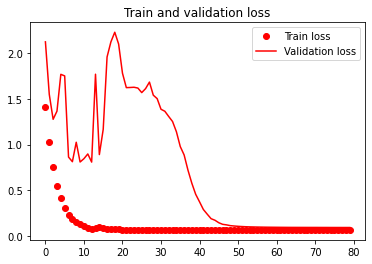

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'ro', label='Train Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Train and validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'ro', label='Train loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Train and validation loss')
plt.legend()
plt.show()

In [ ]:

tra_loss_0 = history.history['loss']
tra_acc_0 = history.history['accuracy']
val_loss_0 = history.history['val_loss']
val_acc_0 = history.history['val_accuracy']

epochs_0 = range(1, len(tra_acc_0)+1)
end_epoch_0 = len(tra_acc_0)

opt_epoch_0 = val_loss_0.index(min(val_loss_0)) + 1

end_val_loss_0 = val_loss_0[-1]
end_val_acc_0 = val_acc_0[-1]
opt_val_loss_0 = val_loss_0[opt_epoch_0-1]
opt_val_acc_0 = val_acc_0[opt_epoch_0-1]

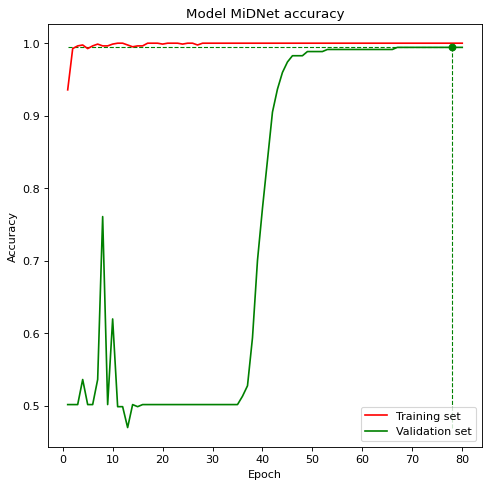

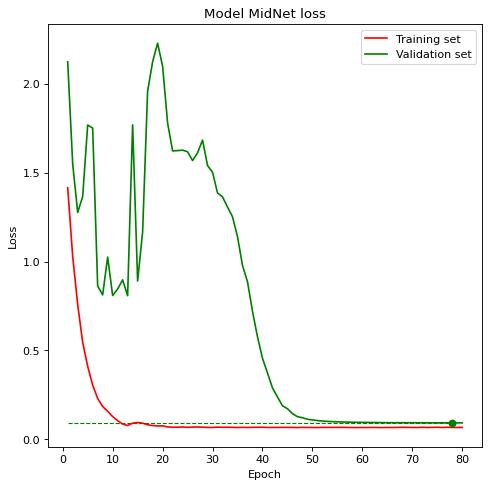

In [ ]:
#Plot accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model MiDNet accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_acc_0, 'r', label='Training set')
plt.plot(epochs_0, val_acc_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_acc_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_acc_0), opt_val_acc_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Plot Loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model MidNet loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_loss_0, 'r', label='Training set')
plt.plot(epochs_0, val_loss_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_loss_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_loss_0), opt_val_loss_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend();

Load weights

In [ ]:
model.load_weights('/content/drive/MyDrive/MiDNetT9_weights.h5')

# Matriz de Confusão

In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [ ]:
predictions_bi = model.predict(testX, verbose=0)
pred_bi = np.argmax(predictions_bi,axis=1)

In [ ]:
y_compare_bi = np.argmax(testY, axis =1)

In [ ]:
print(classification_report(y_compare_bi, pred_bi, digits=3))

              precision    recall  f1-score   support

           0      0.994     0.994     0.994       173
           1      0.994     0.994     0.994       174

    accuracy                          0.994       347
   macro avg      0.994     0.994     0.994       347
weighted avg      0.994     0.994     0.994       347



In [ ]:
print('Confusion Matrix')
print(confusion_matrix(y_compare_bi, pred_bi))

Confusion Matrix
[[172   1]
 [  1 173]]


In [ ]:
cm = confusion_matrix(y_compare_bi, pred_bi)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    Exibe a matriz de confusão e normaliza caso 'normalize' igual a true.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de confusão sem normalização')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_plot_labels = ['0','1']

Confusion matrix, without normalization
[[172   1]
 [  1 173]]


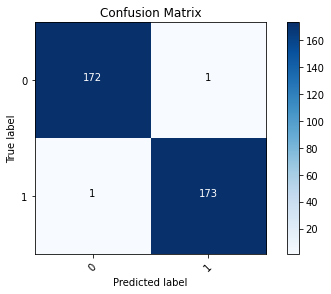

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# AUC e ROC

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc


In [ ]:


yhat = model.predict(testX, verbose=0)
pred_ = np.argmax(yhat,axis=1)
# calculate roc auc
y_comp = np.argmax(testY, axis =1)
roc_auc = roc_auc_score(y_comp, pred_)
print('No Skill ROC AUC %.3f' % roc_auc)

No Skill ROC AUC 0.675


In [ ]:

fpr, tpr, thresholds = roc_curve(y_comp, pred_)

In [ ]:
# função do sklearn
def plot_roc_curve(fpr, tpr):
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

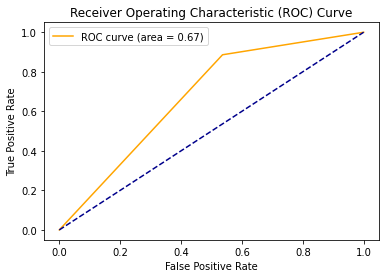

In [ ]:

plot_roc_curve(fpr, tpr)

# Benigno e Maligno

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint ,TensorBoard,ReduceLROnPlateau, EarlyStopping

NAME = "MiDNetBM"

tensorboard = TensorBoard(log_dir = "/content/drive/MyDrive/{}".format(NAME))


filepath = '/content/drive/MyDrive/MiDNetBM_weights.h5' 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only = True, mode = 'max')
lr_reduce = ReduceLROnPlateau(monitor='accuracy', factor=0.1, min_delta=alpha, patience= 5, verbose= 1)

early_stop = EarlyStopping(monitor='val_loss',
min_delta=0.001,
patience=5,
mode='min',
verbose=1)

callbacks = [checkpoint ,lr_reduce,tensorboard]

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(trainX, trainY, steps_per_epoch=len(trainX)//batch_size, validation_data=(testX, testY), validation_steps= len(testX)//batch_size,callbacks=callbacks, epochs = epoch)

Epoch 1/80
9/9 [==============================] - 41s 727ms/step - loss: 1.9851 - accuracy: 0.5694 - val_loss: 1.9742 - val_accuracy: 0.2510

Epoch 00001: val_accuracy improved from -inf to 0.25105, saving model to /content/drive/MyDrive/MiDNetBM_weights.h5
Epoch 2/80
9/9 [==============================] - 2s 215ms/step - loss: 1.7660 - accuracy: 0.7261 - val_loss: 1.7511 - val_accuracy: 0.7490

Epoch 00002: val_accuracy improved from 0.25105 to 0.74895, saving model to /content/drive/MyDrive/MiDNetBM_weights.h5
Epoch 3/80
9/9 [==============================] - 2s 207ms/step - loss: 1.6573 - accuracy: 0.7369 - val_loss: 1.6196 - val_accuracy: 0.7490

Epoch 00003: val_accuracy did not improve from 0.74895
Epoch 4/80
9/9 [==============================] - 2s 214ms/step - loss: 1.5291 - accuracy: 0.7477 - val_loss: 1.5060 - val_accuracy: 0.7490

Epoch 00004: val_accuracy did not improve from 0.74895
Epoch 5/80
9/9 [==============================] - 2s 207ms/step - loss: 1.4203 - accuracy:

In [ ]:
_, acc = model.evaluate( testX,testY, verbose=0)

In [ ]:
print('> %.4f' % (acc * 100.0))

> 71.5481


In [ ]:
tra_loss_9 = history.history['loss']
tra_acc_9 = history.history['accuracy']
val_loss_9 = history.history['val_loss']
val_acc_9 = history.history['val_accuracy']

epochs_9 = range(1, len(tra_acc_9)+1)
end_epoch_9 = len(tra_acc_9)

opt_epoch_9 = val_loss_9.index(min(val_loss_9)) + 1

end_val_loss_9 = val_loss_9[-1]
end_val_acc_9 = val_acc_9[-1]
opt_val_loss_9 = val_loss_9[opt_epoch_9-1]
opt_val_acc_9 = val_acc_9[opt_epoch_9-1]

In [ ]:
print("Epoch [end]: %d" % end_epoch_9)
print("Epoch [opt]: %d" % opt_epoch_9)
print("Valid accuracy [end]: %.4f" % end_val_acc_9)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_9)

print("Valid loss [end]: %.4f" % end_val_loss_9)
print("Valid loss [opt]: %.4f" % opt_val_loss_9)

Epoch [end]: 80
Epoch [opt]: 21
Valid accuracy [end]: 0.7155
Valid accuracy [opt]: 0.7490
Valid loss [end]: 1.1000
Valid loss [opt]: 0.8760


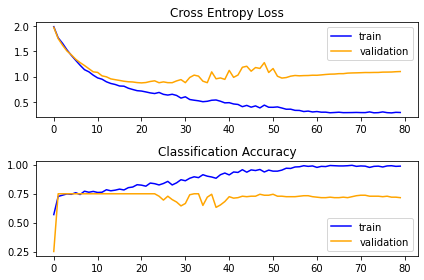

In [ ]:
ax1 = plt.subplot(211)
plt.title('Cross Entropy Loss')
ax1.plot(history.history['loss'], color='blue', label='train')
ax1.plot(history.history['val_loss'], color='orange', label='validation')
ax1.legend()
    # plot accuracy
ax2 = plt.subplot(212)
plt.title('Classification Accuracy')
ax2.plot(history.history['accuracy'], color='blue', label='train')
ax2.plot(history.history['val_accuracy'], color='orange', label='validation')
ax2.legend()
plt.tight_layout()

In [ ]:

tra_loss_0 = history_3.history['loss']
tra_acc_0 = history_3.history['accuracy']
val_loss_0 = history_3.history['val_loss']
val_acc_0 = history_3.history['val_accuracy']

epochs_0 = range(1, len(tra_acc_0)+1)
end_epoch_0 = len(tra_acc_0)

opt_epoch_0 = val_loss_0.index(min(val_loss_0)) + 1

end_val_loss_0 = val_loss_0[-1]
end_val_acc_0 = val_acc_0[-1]
opt_val_loss_0 = val_loss_0[opt_epoch_0-1]
opt_val_acc_0 = val_acc_0[opt_epoch_0-1]

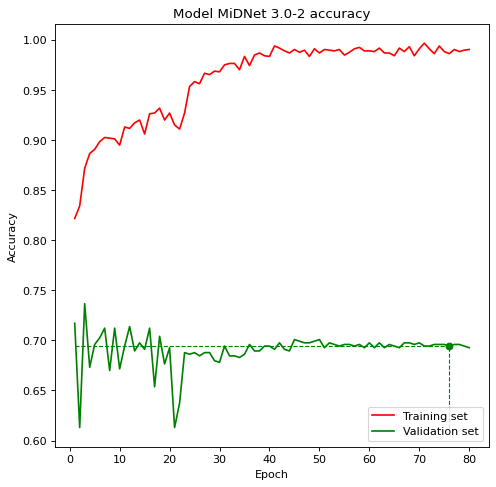

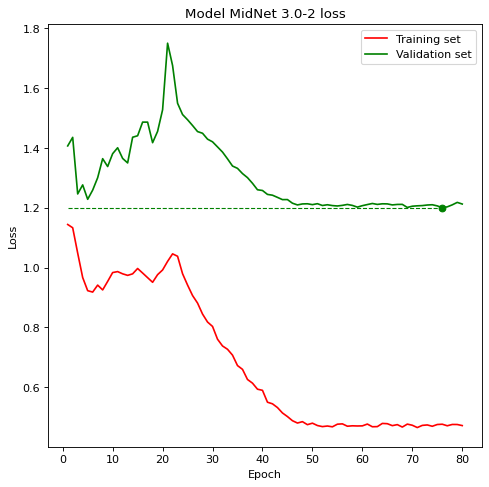

In [ ]:
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model MiDNet 3.0-2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_acc_0, 'r', label='Training set')
plt.plot(epochs_0, val_acc_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_acc_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_acc_0), opt_val_acc_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model MidNet 3.0-2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_loss_0, 'r', label='Training set')
plt.plot(epochs_0, val_loss_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_loss_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_loss_0), opt_val_loss_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
predictions_bi = model.predict(testX, verbose=0)
pred_bi = np.argmax(predictions_bi,axis=1)

In [ ]:
y_compare_bi = np.argmax(testY, axis =1)

In [ ]:
print(classification_report(y_compare_bi, pred_bi, digits=3))

              precision    recall  f1-score   support

           0      0.438     0.467     0.452        60
           1      0.817     0.799     0.808       179

    accuracy                          0.715       239
   macro avg      0.627     0.633     0.630       239
weighted avg      0.722     0.715     0.718       239



In [ ]:
cm = confusion_matrix(y_compare_bi, pred_bi)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de Confusão, sem normalização')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_plot_labels = ['Benigno','Maligno']

Matriz de Confusão, sem normalização
[[ 28  32]
 [ 36 143]]


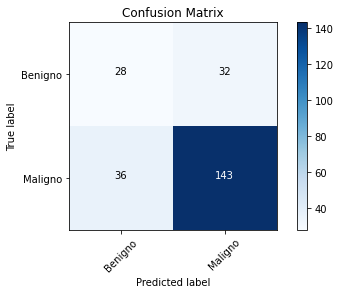

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# Benigno e Maligno - 1

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint ,TensorBoard,ReduceLROnPlateau, EarlyStopping

NAME = "MiDNetBM.1"

tensorboard = TensorBoard(log_dir = "/content/drive/MyDrive/{}".format(NAME))


filepath = '/content/drive/MyDrive/MiDNetBM.1_weights.h5' 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only = True, mode = 'max')
lr_reduce = ReduceLROnPlateau(monitor='accuracy', factor=0.1, min_delta=alpha, patience= 5, verbose= 1)

early_stop = EarlyStopping(monitor='val_loss',
min_delta=0.001,
patience=5,
mode='min',
verbose=1)

callbacks = [checkpoint ,lr_reduce,tensorboard]

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(trainX, trainY, steps_per_epoch=len(trainX)//batch_size, validation_data=(testX, testY), validation_steps= len(testX)//batch_size,callbacks=callbacks, epochs = epoch)

Epoch 1/80
16/16 [==============================] - 43s 529ms/step - loss: 1.8628 - accuracy: 0.6886 - val_loss: 1.6090 - val_accuracy: 0.8585

Epoch 00001: val_accuracy improved from -inf to 0.85851, saving model to /content/drive/MyDrive/MiDNetBM.1_weights.h5
Epoch 2/80
16/16 [==============================] - 4s 222ms/step - loss: 1.5125 - accuracy: 0.8510 - val_loss: 1.3713 - val_accuracy: 0.8585

Epoch 00002: val_accuracy did not improve from 0.85851
Epoch 3/80
16/16 [==============================] - 4s 224ms/step - loss: 1.3133 - accuracy: 0.8571 - val_loss: 1.2004 - val_accuracy: 0.8585

Epoch 00003: val_accuracy did not improve from 0.85851
Epoch 4/80
16/16 [==============================] - 3s 219ms/step - loss: 1.1353 - accuracy: 0.8571 - val_loss: 1.0772 - val_accuracy: 0.8585

Epoch 00004: val_accuracy did not improve from 0.85851
Epoch 5/80
16/16 [==============================] - 3s 213ms/step - loss: 0.9997 - accuracy: 0.8561 - val_loss: 0.9712 - val_accuracy: 0.8585

E

In [ ]:
_, acc = model.evaluate( testX,testY, verbose=0)

In [ ]:
print('> %.4f' % (acc * 100.0))

> 86.5707


In [ ]:
tra_loss_9 = history.history['loss']
tra_acc_9 = history.history['accuracy']
val_loss_9 = history.history['val_loss']
val_acc_9 = history.history['val_accuracy']

epochs_9 = range(1, len(tra_acc_9)+1)
end_epoch_9 = len(tra_acc_9)

opt_epoch_9 = val_loss_9.index(min(val_loss_9)) + 1

end_val_loss_9 = val_loss_9[-1]
end_val_acc_9 = val_acc_9[-1]
opt_val_loss_9 = val_loss_9[opt_epoch_9-1]
opt_val_acc_9 = val_acc_9[opt_epoch_9-1]

In [ ]:
print("Epoch [end]: %d" % end_epoch_9)
print("Epoch [opt]: %d" % opt_epoch_9)
print("Valid accuracy [end]: %.4f" % end_val_acc_9)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_9)

print("Valid loss [end]: %.4f" % end_val_loss_9)
print("Valid loss [opt]: %.4f" % opt_val_loss_9)

Epoch [end]: 80
Epoch [opt]: 53
Valid accuracy [end]: 0.8657
Valid accuracy [opt]: 0.8585
Valid loss [end]: 0.6865
Valid loss [opt]: 0.6465


In [ ]:
import matplotlib.pyplot as plt


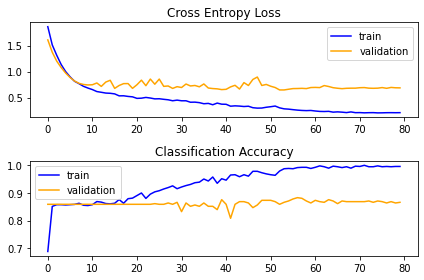

In [ ]:
ax1 = plt.subplot(211)
plt.title('Cross Entropy Loss')
ax1.plot(history.history['loss'], color='blue', label='train')
ax1.plot(history.history['val_loss'], color='orange', label='validation')
ax1.legend()
    # plot accuracy
ax2 = plt.subplot(212)
plt.title('Classification Accuracy')
ax2.plot(history.history['accuracy'], color='blue', label='train')
ax2.plot(history.history['val_accuracy'], color='orange', label='validation')
ax2.legend()
plt.tight_layout()

In [ ]:
predictions_bi = model.predict(testX, verbose=0)
pred_bi = np.argmax(predictions_bi,axis=1)

In [ ]:
y_compare_bi = np.argmax(testY, axis =1)

In [ ]:
print(classification_report(y_compare_bi, pred_bi, digits=3))

              precision    recall  f1-score   support

           0      0.543     0.322     0.404        59
           1      0.895     0.955     0.924       358

    accuracy                          0.866       417
   macro avg      0.719     0.639     0.664       417
weighted avg      0.845     0.866     0.851       417



In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de Confusão, sem normalização')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm = confusion_matrix(y_compare_bi, pred_bi)

In [ ]:
cm_plot_labels = ['Benigno','Maligno']

Matriz de Confusão, sem normalização
[[ 99 106]
 [ 45 350]]


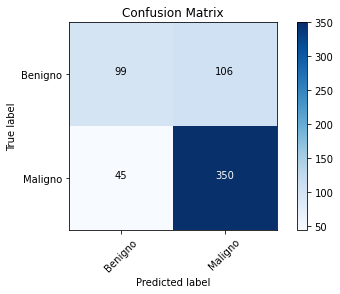

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
print('> %.4f' % (acc * 100.0))

> 86.5707


# Experimento O

In [ ]:
model.load_weights('/content/drive/MyDrive/MiDNet3.0-1_weights.h5')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint ,TensorBoard,ReduceLROnPlateau, EarlyStopping

NAME = "MiDNet3.0-2"

tensorboard = TensorBoard(log_dir = "/content/drive/MyDrive/{}".format(NAME))


filepath = '/content/drive/MyDrive/MiDNet3.0-2_weights.h5' 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only = True, mode = 'max')
lr_reduce = ReduceLROnPlateau(monitor='accuracy', factor=0.1, min_delta=alpha, patience= 5, verbose= 1)

early_stop = EarlyStopping(monitor='val_loss',
min_delta=0.001,
patience=5,
mode='min',
verbose=1)

callbacks = [checkpoint, early_stop ,lr_reduce,tensorboard]

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_0 = model.fit(trainX, trainY, steps_per_epoch=len(trainX)//batch_size, validation_data=(testX, testY), validation_steps= len(testX)//batch_size,callbacks=callbacks, epochs = epoch)


Epoch 1/80
13/13 [==============================] - 4s 332ms/step - loss: 0.0958 - accuracy: 0.9864 - val_loss: 0.4942 - val_accuracy: 0.9337

Epoch 00001: val_accuracy improved from -inf to 0.93372, saving model to /content/drive/MyDrive/MiDNet3.0-2_weights.h5
Epoch 2/80
13/13 [==============================] - 3s 212ms/step - loss: 0.1007 - accuracy: 0.9913 - val_loss: 4.4598 - val_accuracy: 0.4986

Epoch 00002: val_accuracy did not improve from 0.93372
Epoch 3/80
13/13 [==============================] - 3s 231ms/step - loss: 0.1106 - accuracy: 0.9926 - val_loss: 2.4965 - val_accuracy: 0.5216

Epoch 00003: val_accuracy did not improve from 0.93372
Epoch 4/80
13/13 [==============================] - 3s 233ms/step - loss: 0.0971 - accuracy: 0.9988 - val_loss: 3.9047 - val_accuracy: 0.4986

Epoch 00004: val_accuracy did not improve from 0.93372
Epoch 5/80
13/13 [==============================] - 3s 234ms/step - loss: 0.0866 - accuracy: 0.9975 - val_loss: 0.2453 - val_accuracy: 0.9654

E

In [ ]:
_, acc = model.evaluate( testX,testY, verbose=0)

In [ ]:
print('> %.4f' % (acc * 100.0))

> 97.9827


In [ ]:

tra_loss_9 = history_0.history['loss']
tra_acc_9 = history_0.history['accuracy']
val_loss_9 = history_0.history['val_loss']
val_acc_9 = history_0.history['val_accuracy']

epochs_9 = range(1, len(tra_acc_9)+1)
end_epoch_9 = len(tra_acc_9)

opt_epoch_9 = val_loss_9.index(min(val_loss_9)) + 1

end_val_loss_9 = val_loss_9[-1]
end_val_acc_9 = val_acc_9[-1]
opt_val_loss_9 = val_loss_9[opt_epoch_9-1]
opt_val_acc_9 = val_acc_9[opt_epoch_9-1]

In [ ]:
print("Epoch [end]: %d" % end_epoch_9)
print("Epoch [opt]: %d" % opt_epoch_9)
print("Valid accuracy [end]: %.4f" % end_val_acc_9)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_9)

print("Valid loss [end]: %.4f" % end_val_loss_9)
print("Valid loss [opt]: %.4f" % opt_val_loss_9)

Epoch [end]: 17
Epoch [opt]: 12
Valid accuracy [end]: 0.9798
Valid accuracy [opt]: 0.9798
Valid loss [end]: 0.1076
Valid loss [opt]: 0.0993


<h1>Gráficos</h1>

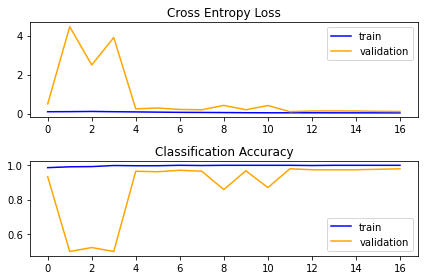

In [ ]:
ax1 = plt.subplot(211)
plt.title('Cross Entropy Loss')
ax1.plot(history_0.history['loss'], color='blue', label='train')
ax1.plot(history_0.history['val_loss'], color='orange', label='validation')
ax1.legend()
    # plot accuracy
ax2 = plt.subplot(212)
plt.title('Classification Accuracy')
ax2.plot(history_0.history['accuracy'], color='blue', label='train')
ax2.plot(history_0.history['val_accuracy'], color='orange', label='validation')
ax2.legend()
plt.tight_layout()

In [ ]:

tra_loss_0 = history_0.history['loss']
tra_acc_0 = history_0.history['accuracy']
val_loss_0 = history_0.history['val_loss']
val_acc_0 = history_0.history['val_accuracy']

epochs_0 = range(1, len(tra_acc_0)+1)
end_epoch_0 = len(tra_acc_0)

opt_epoch_0 = val_loss_0.index(min(val_loss_0)) + 1

end_val_loss_0 = val_loss_0[-1]
end_val_acc_0 = val_acc_0[-1]
opt_val_loss_0 = val_loss_0[opt_epoch_0-1]
opt_val_acc_0 = val_acc_0[opt_epoch_0-1]

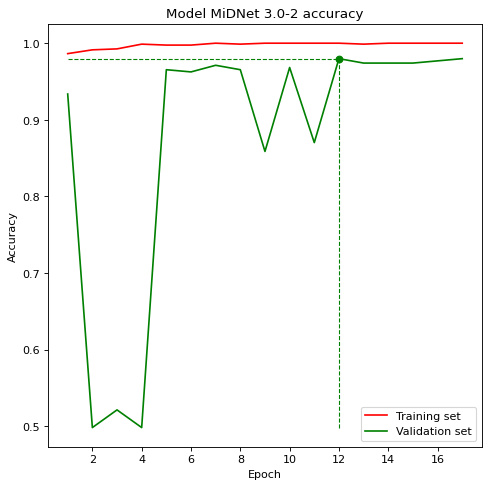

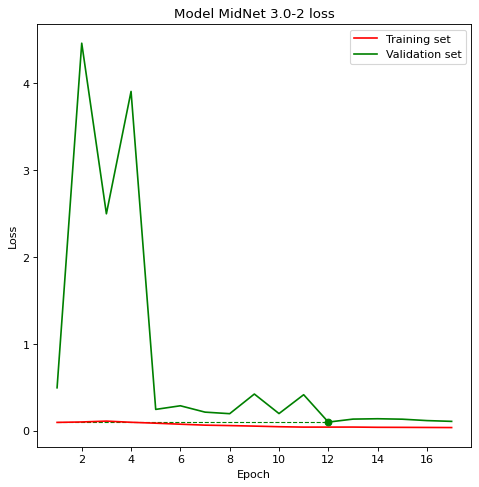

In [ ]:

plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model MiDNet 3.0-2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_acc_0, 'r', label='Training set')
plt.plot(epochs_0, val_acc_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_acc_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_acc_0), opt_val_acc_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model MidNet 3.0-2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_loss_0, 'r', label='Training set')
plt.plot(epochs_0, val_loss_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_loss_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_loss_0), opt_val_loss_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
predictions_bi = model.predict(testX, verbose=0)
pred_bi = np.argmax(predictions_bi,axis=1)

In [ ]:
y_compare_bi = np.argmax(testY, axis =1)

In [ ]:
print(classification_report(y_compare_bi, pred_bi, digits=3))

              precision    recall  f1-score   support

           0      0.966     0.994     0.980       173
           1      0.994     0.966     0.980       174

    accuracy                          0.980       347
   macro avg      0.980     0.980     0.980       347
weighted avg      0.980     0.980     0.980       347



In [ ]:
print('Confusion Matrix')
print(confusion_matrix(y_compare_bi, pred_bi))

Confusion Matrix
[[172   1]
 [  6 168]]


In [ ]:
cm = confusion_matrix(y_compare_bi, pred_bi)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de Confusão, sem normalização')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_plot_labels = ['0','1']

Confusion matrix, without normalization
[[172   1]
 [  6 168]]


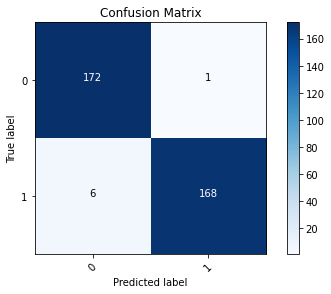

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# Experimento 1

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint ,TensorBoard,ReduceLROnPlateau, EarlyStopping

NAME = "MiDNet3.0-4"

tensorboard = TensorBoard(log_dir = "/content/drive/MyDrive/{}".format(NAME))


filepath = '/content/drive/MyDrive/MiDNet3.0-4_weights.h5' 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only = True, mode = 'max')
lr_reduce = ReduceLROnPlateau(monitor='accuracy', factor=0.1, min_delta=alpha, patience= 5, verbose= 1)

early_stop = EarlyStopping(monitor='val_loss',
min_delta=0.001,
patience=5,
mode='min',
verbose=1)

callbacks = [checkpoint, early_stop ,lr_reduce,tensorboard]

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_1 = model.fit(trainX, trainY, steps_per_epoch=len(trainX)//batch_size, validation_data=(testX, testY), validation_steps= len(testX)//batch_size,callbacks=callbacks, epochs = epoch)


Epoch 1/80
15/15 [==============================] - 9s 405ms/step - loss: 0.3942 - accuracy: 0.9109 - val_loss: 0.3358 - val_accuracy: 0.9392

Epoch 00001: val_accuracy improved from -inf to 0.93924, saving model to /content/drive/MyDrive/MiDNet3.0-4_weights.h5
Epoch 2/80
15/15 [==============================] - 3s 209ms/step - loss: 0.2464 - accuracy: 0.9402 - val_loss: 0.6670 - val_accuracy: 0.7696

Epoch 00002: val_accuracy did not improve from 0.93924
Epoch 3/80
15/15 [==============================] - 3s 222ms/step - loss: 0.2185 - accuracy: 0.9598 - val_loss: 0.3530 - val_accuracy: 0.9038

Epoch 00003: val_accuracy did not improve from 0.93924
Epoch 4/80
15/15 [==============================] - 3s 208ms/step - loss: 0.2241 - accuracy: 0.9620 - val_loss: 1.1300 - val_accuracy: 0.7367

Epoch 00004: val_accuracy did not improve from 0.93924
Epoch 5/80
15/15 [==============================] - 3s 210ms/step - loss: 0.2343 - accuracy: 0.9685 - val_loss: 0.3798 - val_accuracy: 0.9418

E

In [ ]:
_, acc = model.evaluate( testX,testY, verbose=0)

In [ ]:
print('> %.4f' % (acc * 100.0))

> 92.6582


In [ ]:
tra_loss_9 = history_1.history['loss']
tra_acc_9 = history_1.history['accuracy']
val_loss_9 = history_1.history['val_loss']
val_acc_9 = history_1.history['val_accuracy']

epochs_9 = range(1, len(tra_acc_9)+1)
end_epoch_9 = len(tra_acc_9)

opt_epoch_9 = val_loss_9.index(min(val_loss_9)) + 1

end_val_loss_9 = val_loss_9[-1]
end_val_acc_9 = val_acc_9[-1]
opt_val_loss_9 = val_loss_9[opt_epoch_9-1]
opt_val_acc_9 = val_acc_9[opt_epoch_9-1]

In [ ]:
print("Epoch [end]: %d" % end_epoch_9)
print("Epoch [opt]: %d" % opt_epoch_9)
print("Valid accuracy [end]: %.4f" % end_val_acc_9)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_9)

print("Valid loss [end]: %.4f" % end_val_loss_9)
print("Valid loss [opt]: %.4f" % opt_val_loss_9)

Epoch [end]: 6
Epoch [opt]: 1
Valid accuracy [end]: 0.9266
Valid accuracy [opt]: 0.9392
Valid loss [end]: 0.4584
Valid loss [opt]: 0.3358


<h1>Gráficos</h1>

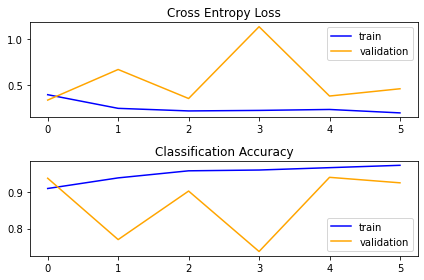

In [ ]:
ax1 = plt.subplot(211)
plt.title('Cross Entropy Loss')
ax1.plot(history_1.history['loss'], color='blue', label='train')
ax1.plot(history_1.history['val_loss'], color='orange', label='validation')
ax1.legend()
    # plot accuracy
ax2 = plt.subplot(212)
plt.title('Classification Accuracy')
ax2.plot(history_1.history['accuracy'], color='blue', label='train')
ax2.plot(history_1.history['val_accuracy'], color='orange', label='validation')
ax2.legend()
plt.tight_layout()

In [ ]:
tra_loss_0 = history_1.history['loss']
tra_acc_0 = history_1.history['accuracy']
val_loss_0 = history_1.history['val_loss']
val_acc_0 = history_1.history['val_accuracy']

epochs_0 = range(1, len(tra_acc_0)+1)
end_epoch_0 = len(tra_acc_0)

opt_epoch_0 = val_loss_0.index(min(val_loss_0)) + 1

end_val_loss_0 = val_loss_0[-1]
end_val_acc_0 = val_acc_0[-1]
opt_val_loss_0 = val_loss_0[opt_epoch_0-1]
opt_val_acc_0 = val_acc_0[opt_epoch_0-1]

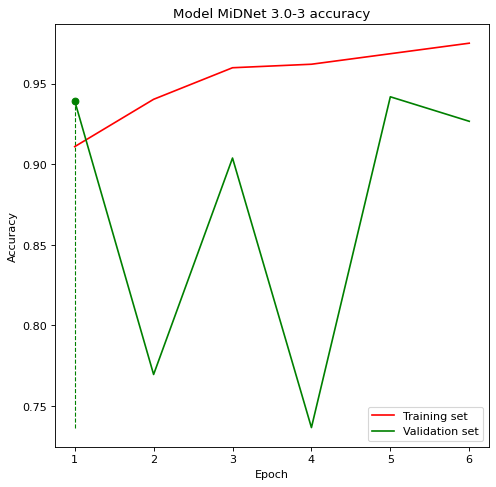

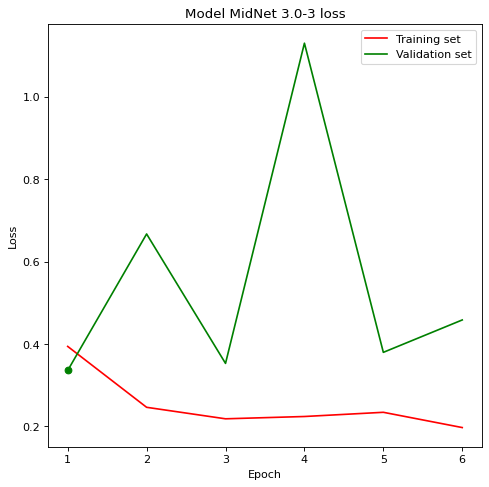

In [ ]:
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model MiDNet 3.0-3 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_acc_0, 'r', label='Training set')
plt.plot(epochs_0, val_acc_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_acc_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_acc_0), opt_val_acc_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model MidNet 3.0-3 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_loss_0, 'r', label='Training set')
plt.plot(epochs_0, val_loss_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_loss_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_loss_0), opt_val_loss_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
predictions_bi = model.predict(testX, verbose=0)
pred_bi = np.argmax(predictions_bi,axis=1)

In [ ]:
y_compare_bi = np.argmax(testY, axis =1)

In [ ]:
print(classification_report(y_compare_bi, pred_bi, digits=4))

              precision    recall  f1-score   support

           0     0.8784    0.9898    0.9308       197
           1     0.9884    0.8636    0.9218       198

    accuracy                         0.9266       395
   macro avg     0.9334    0.9267    0.9263       395
weighted avg     0.9335    0.9266    0.9263       395



In [ ]:
print('Confusion Matrix')
print(confusion_matrix(y_compare_bi, pred_bi))

Confusion Matrix
[[195   2]
 [ 27 171]]


In [ ]:
cm = confusion_matrix(y_compare_bi, pred_bi)

In [ ]:
cm_plot_labels = ['0','1']

Confusion matrix, without normalization
[[195   2]
 [ 27 171]]


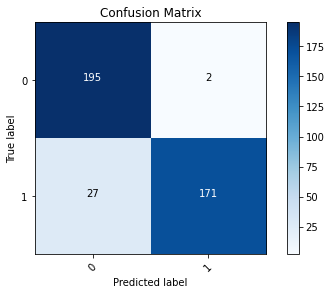

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Roc e AUc

In [ ]:
yhat1 = model.predict(testX, verbose=0)
pred1_ = np.argmax(yhat1,axis=1)
# calculate roc auc
y_comp1 = np.argmax(testY, axis =1)
roc_auc = roc_auc_score(y_comp1, pred1_)
print('No Skill ROC AUC %.4f' % roc_auc)

No Skill ROC AUC 0.9267


In [ ]:
fpr, tpr, thresholds = roc_curve(y_comp1, pred1_)

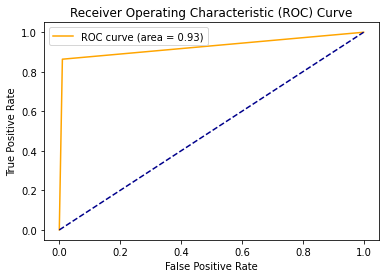

In [ ]:

plot_roc_curve(fpr, tpr)

# Experimento 2

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint ,TensorBoard,ReduceLROnPlateau, EarlyStopping

NAME = "MiDNet3.0-5"

tensorboard = TensorBoard(log_dir = "/content/drive/MyDrive/{}".format(NAME))


filepath = '/content/drive/MyDrive/MiDNet3.0-5_weights.h5' 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only = True, mode = 'max')
lr_reduce = ReduceLROnPlateau(monitor='accuracy', factor=0.1, min_delta=alpha, patience= 5, verbose= 1)

early_stop = EarlyStopping(monitor='val_loss',
min_delta=0.001,
patience=5,
mode='min',
verbose=1)

callbacks = [checkpoint, early_stop ,lr_reduce,tensorboard]

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_2 = model.fit(trainX, trainY, steps_per_epoch=len(trainX)//batch_size, validation_data=(testX, testY), validation_steps= len(testX)//batch_size,callbacks=callbacks, epochs = epoch)


Epoch 1/80
15/15 [==============================] - 20s 537ms/step - loss: 0.3040 - accuracy: 0.9398 - val_loss: 0.8572 - val_accuracy: 0.8990

Epoch 00001: val_accuracy improved from -inf to 0.89901, saving model to /content/drive/MyDrive/MiDNet3.0-5_weights.h5
Epoch 2/80
15/15 [==============================] - 3s 212ms/step - loss: 0.2925 - accuracy: 0.9514 - val_loss: 0.6784 - val_accuracy: 0.9089

Epoch 00002: val_accuracy improved from 0.89901 to 0.90887, saving model to /content/drive/MyDrive/MiDNet3.0-5_weights.h5
Epoch 3/80
15/15 [==============================] - 3s 227ms/step - loss: 0.2441 - accuracy: 0.9652 - val_loss: 0.3408 - val_accuracy: 0.9187

Epoch 00003: val_accuracy improved from 0.90887 to 0.91872, saving model to /content/drive/MyDrive/MiDNet3.0-5_weights.h5
Epoch 4/80
15/15 [==============================] - 3s 226ms/step - loss: 0.2172 - accuracy: 0.9704 - val_loss: 0.3830 - val_accuracy: 0.8966

Epoch 00004: val_accuracy did not improve from 0.91872
Epoch 5/8

In [ ]:
_, acc = model.evaluate( testX,testY, verbose=0)

In [ ]:
print('> %.4f' % (acc * 100.0))

> 96.0591


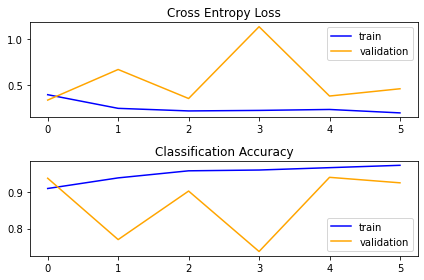

In [ ]:
ax1 = plt.subplot(211)
plt.title('Cross Entropy Loss')
ax1.plot(history_1.history['loss'], color='blue', label='train')
ax1.plot(history_1.history['val_loss'], color='orange', label='validation')
ax1.legend()
    # plot accuracy
ax2 = plt.subplot(212)
plt.title('Classification Accuracy')
ax2.plot(history_1.history['accuracy'], color='blue', label='train')
ax2.plot(history_1.history['val_accuracy'], color='orange', label='validation')
ax2.legend()
plt.tight_layout()

In [ ]:
tra_loss_9 = history_2.history['loss']
tra_acc_9 = history_2.history['accuracy']
val_loss_9 = history_2.history['val_loss']
val_acc_9 = history_2.history['val_accuracy']

epochs_9 = range(1, len(tra_acc_9)+1)
end_epoch_9 = len(tra_acc_9)

opt_epoch_9 = val_loss_9.index(min(val_loss_9)) + 1

end_val_loss_9 = val_loss_9[-1]
end_val_acc_9 = val_acc_9[-1]
opt_val_loss_9 = val_loss_9[opt_epoch_9-1]
opt_val_acc_9 = val_acc_9[opt_epoch_9-1]

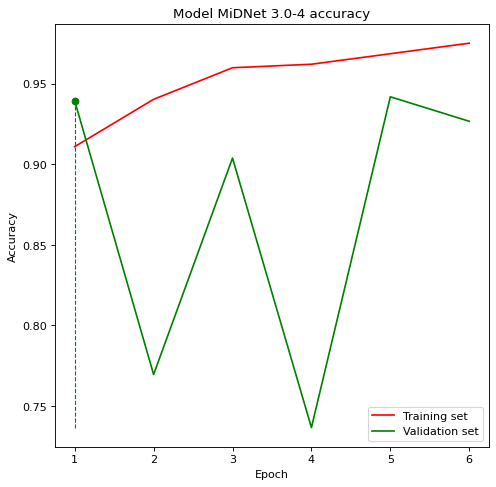

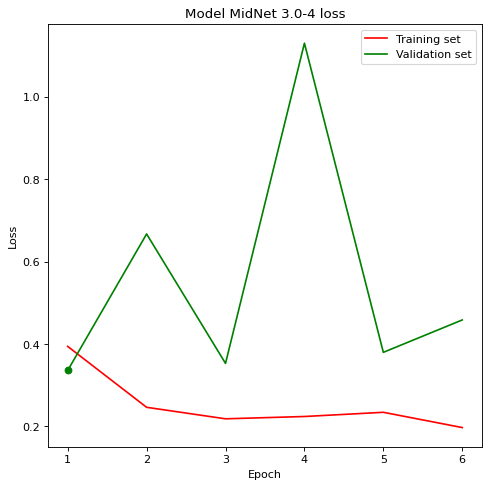

In [ ]:
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model MiDNet 3.0-4 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_acc_0, 'r', label='Training set')
plt.plot(epochs_0, val_acc_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_acc_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_acc_0), opt_val_acc_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model MidNet 3.0-4 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_loss_0, 'r', label='Training set')
plt.plot(epochs_0, val_loss_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_loss_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_loss_0), opt_val_loss_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
predictions_bi = model.predict(testX, verbose=0)
pred_bi = np.argmax(predictions_bi,axis=1)

In [ ]:
y_compare_bi = np.argmax(testY, axis =1)

In [ ]:
print(classification_report(y_compare_bi, pred_bi, digits=4))

              precision    recall  f1-score   support

           0     0.9330    0.9898    0.9606       197
           1     0.9898    0.9330    0.9606       209

    accuracy                         0.9606       406
   macro avg     0.9614    0.9614    0.9606       406
weighted avg     0.9623    0.9606    0.9606       406



In [ ]:
cm = confusion_matrix(y_compare_bi, pred_bi)

In [ ]:
cm_plot_labels = ['0','1']

Confusion matrix, without normalization
[[195   2]
 [ 14 195]]


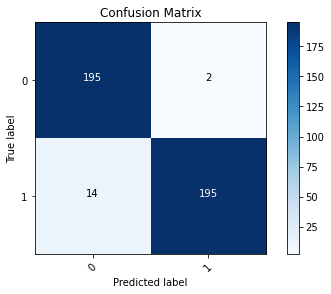

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
yhat2 = model.predict(testX, verbose=0)
pred2_ = np.argmax(yhat2,axis=1)
# calculate roc auc
y_comp2 = np.argmax(testY, axis =1)
roc_auc = roc_auc_score(y_comp2, pred1_)
print('No Skill ROC AUC %.4f' % roc_auc)

No Skill ROC AUC 0.9614


In [ ]:
fpr, tpr, thresholds = roc_curve(y_comp2, pred2_)

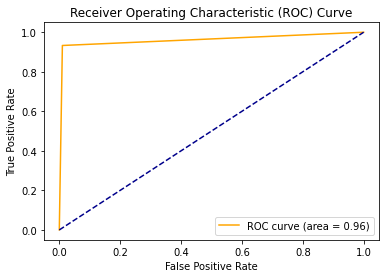

In [ ]:

plot_roc_curve(fpr, tpr)

# Experimento 3

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint ,TensorBoard,ReduceLROnPlateau, EarlyStopping

NAME = "MiDNet3.0-"

tensorboard = TensorBoard(log_dir = "/content/drive/MyDrive/{}".format(NAME))


filepath = '/content/drive/MyDrive/MiDNet3.0-6_weights.h5' 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only = True, mode = 'max')
lr_reduce = ReduceLROnPlateau(monitor='accuracy', factor=0.1, min_delta=alpha, patience= 5, verbose= 1)

early_stop = EarlyStopping(monitor='val_loss',
min_delta=0.001,
patience=5,
mode='min',
verbose=1)

callbacks = [checkpoint,lr_reduce,tensorboard]

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_3 = model.fit(trainX, trainY, steps_per_epoch=len(trainX)//batch_size, validation_data=(testX, testY), validation_steps= len(testX)//batch_size,callbacks=callbacks, epochs = epoch)


Epoch 1/80
13/13 [==============================] - 39s 616ms/step - loss: 1.7295 - accuracy: 0.7911 - val_loss: 2.9036 - val_accuracy: 0.4985

Epoch 00001: val_accuracy improved from -inf to 0.49853, saving model to /content/drive/MyDrive/MiDNet3.0-6_weights.h5
Epoch 2/80
13/13 [==============================] - 3s 211ms/step - loss: 1.3548 - accuracy: 0.9152 - val_loss: 2.8800 - val_accuracy: 0.4985

Epoch 00002: val_accuracy did not improve from 0.49853
Epoch 3/80
13/13 [==============================] - 3s 210ms/step - loss: 1.1361 - accuracy: 0.9456 - val_loss: 2.8617 - val_accuracy: 0.4985

Epoch 00003: val_accuracy did not improve from 0.49853
Epoch 4/80
13/13 [==============================] - 3s 210ms/step - loss: 0.9613 - accuracy: 0.9506 - val_loss: 2.9633 - val_accuracy: 0.4985

Epoch 00004: val_accuracy did not improve from 0.49853
Epoch 5/80
13/13 [==============================] - 3s 209ms/step - loss: 0.8426 - accuracy: 0.9570 - val_loss: 3.0937 - val_accuracy: 0.4985



In [ ]:
_, acc = model.evaluate( testX,testY, verbose=0)

In [ ]:
print('> %.4f' % (acc * 100.0))

> 89.9705


In [ ]:
import matplotlib.pyplot as plt

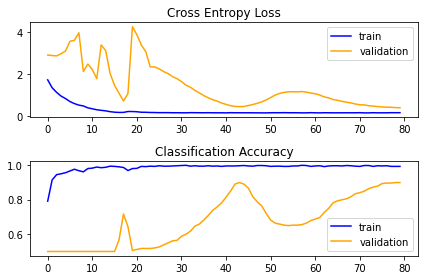

In [ ]:
ax1 = plt.subplot(211)
plt.title('Cross Entropy Loss')
ax1.plot(history_3.history['loss'], color='blue', label='train')
ax1.plot(history_3.history['val_loss'], color='orange', label='validation')
ax1.legend()
    # plot accuracy
ax2 = plt.subplot(212)
plt.title('Classification Accuracy')
ax2.plot(history_3.history['accuracy'], color='blue', label='train')
ax2.plot(history_3.history['val_accuracy'], color='orange', label='validation')
ax2.legend()
plt.tight_layout()

In [ ]:
tra_loss_0 = history_3.history['loss']
tra_acc_0 = history_3.history['accuracy']
val_loss_0 = history_3.history['val_loss']
val_acc_0 = history_3.history['val_accuracy']

epochs_0 = range(1, len(tra_acc_0)+1)
end_epoch_0 = len(tra_acc_0)

opt_epoch_0 = val_loss_0.index(min(val_loss_0)) + 1

end_val_loss_0 = val_loss_0[-1]
end_val_acc_0 = val_acc_0[-1]
opt_val_loss_0 = val_loss_0[opt_epoch_0-1]
opt_val_acc_0 = val_acc_0[opt_epoch_0-1]

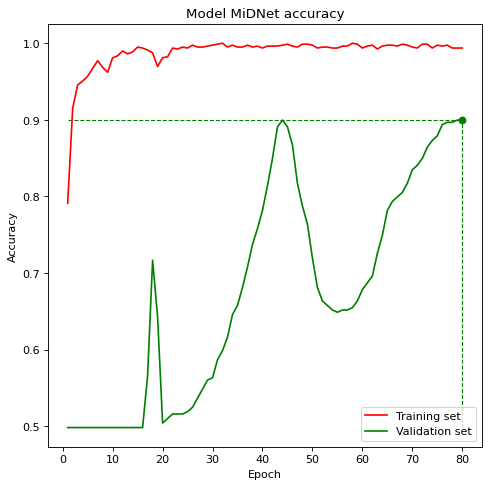

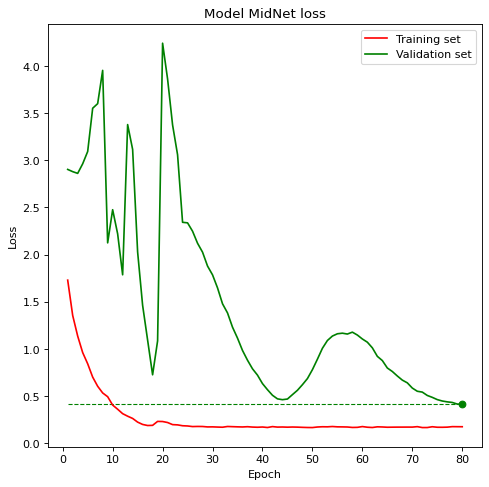

In [ ]:
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model MiDNet accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_acc_0, 'r', label='Training set')
plt.plot(epochs_0, val_acc_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_acc_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_acc_0), opt_val_acc_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model MidNet loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_loss_0, 'r', label='Training set')
plt.plot(epochs_0, val_loss_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_loss_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_loss_0), opt_val_loss_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
predictions_bi = model.predict(testX, verbose=0)
pred_bi = np.argmax(predictions_bi,axis=1)

In [ ]:
y_compare_bi = np.argmax(testY, axis =1)

In [ ]:
print(classification_report(y_compare_bi, pred_bi, digits=4))

              precision    recall  f1-score   support

           0     0.8325    1.0000    0.9086       169
           1     1.0000    0.8000    0.8889       170

    accuracy                         0.8997       339
   macro avg     0.9163    0.9000    0.8987       339
weighted avg     0.9165    0.8997    0.8987       339



In [ ]:
cm = confusion_matrix(y_compare_bi, pred_bi)

In [ ]:
cm_plot_labels = ['0','1']

Confusion matrix, without normalization
[[169   0]
 [ 34 136]]


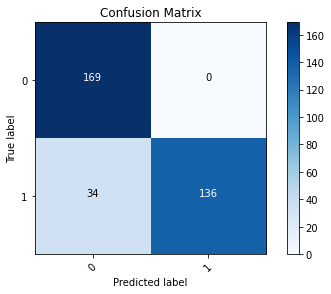

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
yhat3 = model.predict(testX, verbose=0)
pred3_ = np.argmax(yhat3,axis=1)
# calculate roc auc
y_comp3 = np.argmax(testY, axis =1)
roc_auc = roc_auc_score(y_comp3, pred3_)
print('No Skill ROC AUC %.4f' % roc_auc)

No Skill ROC AUC 0.9000


In [ ]:
fpr, tpr, thresholds = roc_curve(y_comp3, pred3_)

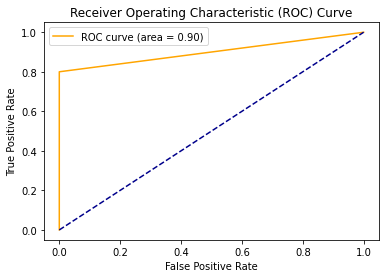

In [ ]:

plot_roc_curve(fpr, tpr)

# Experimento 4

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint ,TensorBoard,ReduceLROnPlateau, EarlyStopping

NAME = "MiDNet3.0-7"

tensorboard = TensorBoard(log_dir = "/content/drive/MyDrive/{}".format(NAME))


filepath = '/content/drive/MyDrive/MiDNet3.0-7_weights.h5' 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only = True, mode = 'max')
lr_reduce = ReduceLROnPlateau(monitor='accuracy', factor=0.1, min_delta=alpha, patience= 5, verbose= 1)

early_stop = EarlyStopping(monitor='val_loss',
min_delta=0.001,
patience=5,
mode='min',
verbose=1)

callbacks = [checkpoint,early_stop,lr_reduce,tensorboard]

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_4 = model.fit(trainX, trainY, steps_per_epoch=len(trainX)//batch_size, validation_data=(testX, testY), validation_steps= len(testX)//batch_size,callbacks=callbacks, epochs = epoch)


Epoch 1/80
15/15 [==============================] - 10s 505ms/step - loss: 0.2570 - accuracy: 0.9646 - val_loss: 0.8969 - val_accuracy: 0.7257

Epoch 00001: val_accuracy improved from -inf to 0.72566, saving model to /content/drive/MyDrive/MiDNet3.0-7_weights.h5
Epoch 2/80
15/15 [==============================] - 3s 195ms/step - loss: 0.2218 - accuracy: 0.9790 - val_loss: 0.5142 - val_accuracy: 0.8451

Epoch 00002: val_accuracy improved from 0.72566 to 0.84513, saving model to /content/drive/MyDrive/MiDNet3.0-7_weights.h5
Epoch 3/80
15/15 [==============================] - 3s 195ms/step - loss: 0.2463 - accuracy: 0.9701 - val_loss: 2.5488 - val_accuracy: 0.5929

Epoch 00003: val_accuracy did not improve from 0.84513
Epoch 4/80
15/15 [==============================] - 3s 195ms/step - loss: 0.2117 - accuracy: 0.9790 - val_loss: 1.9057 - val_accuracy: 0.6195

Epoch 00004: val_accuracy did not improve from 0.84513
Epoch 5/80
15/15 [==============================] - 3s 196ms/step - loss: 0.

In [ ]:
model.load_weights('/content/drive/MyDrive/MiDNet3.0-7_weights.h5')

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_5 = model.fit(trainX, trainY, steps_per_epoch=len(trainX)//batch_size, validation_data=(testX, testY), validation_steps= len(testX)//batch_size,callbacks=callbacks, epochs = epoch)


Epoch 1/80
15/15 [==============================] - 6s 277ms/step - loss: 0.2145 - accuracy: 0.9745 - val_loss: 9.5282 - val_accuracy: 0.5000

Epoch 00001: val_accuracy did not improve from 0.86726
Epoch 2/80
15/15 [==============================] - 3s 193ms/step - loss: 0.1694 - accuracy: 0.9911 - val_loss: 2.8360 - val_accuracy: 0.5619

Epoch 00002: val_accuracy did not improve from 0.86726
Epoch 3/80
15/15 [==============================] - 3s 193ms/step - loss: 0.1554 - accuracy: 0.9956 - val_loss: 1.6149 - val_accuracy: 0.6327

Epoch 00003: val_accuracy did not improve from 0.86726
Epoch 4/80
15/15 [==============================] - 3s 191ms/step - loss: 0.1762 - accuracy: 0.9823 - val_loss: 0.6349 - val_accuracy: 0.8186

Epoch 00004: val_accuracy did not improve from 0.86726
Epoch 5/80
15/15 [==============================] - 3s 195ms/step - loss: 0.1598 - accuracy: 0.9900 - val_loss: 0.6401 - val_accuracy: 0.7920

Epoch 00005: val_accuracy did not improve from 0.86726
Epoch 6/80

In [ ]:
_, acc = model.evaluate( testX,testY, verbose=0)

In [ ]:
print('> %.4f' % (acc * 100.0))

> 81.8584


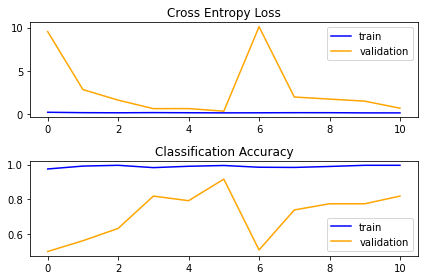

In [ ]:
ax1 = plt.subplot(211)
plt.title('Cross Entropy Loss')
ax1.plot(history_5.history['loss'], color='blue', label='train')
ax1.plot(history_5.history['val_loss'], color='orange', label='validation')
ax1.legend()
    # plot accuracy
ax2 = plt.subplot(212)
plt.title('Classification Accuracy')
ax2.plot(history_5.history['accuracy'], color='blue', label='train')
ax2.plot(history_5.history['val_accuracy'], color='orange', label='validation')
ax2.legend()
plt.tight_layout()

In [ ]:
tra_loss_0 = history_5.history['loss']
tra_acc_0 = history_5.history['accuracy']
val_loss_0 = history_5.history['val_loss']
val_acc_0 = history_5.history['val_accuracy']

epochs_0 = range(1, len(tra_acc_0)+1)
end_epoch_0 = len(tra_acc_0)

opt_epoch_0 = val_loss_0.index(min(val_loss_0)) + 1

end_val_loss_0 = val_loss_0[-1]
end_val_acc_0 = val_acc_0[-1]
opt_val_loss_0 = val_loss_0[opt_epoch_0-1]
opt_val_acc_0 = val_acc_0[opt_epoch_0-1]

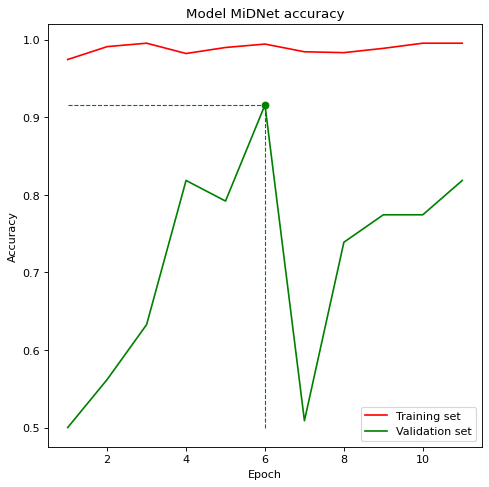

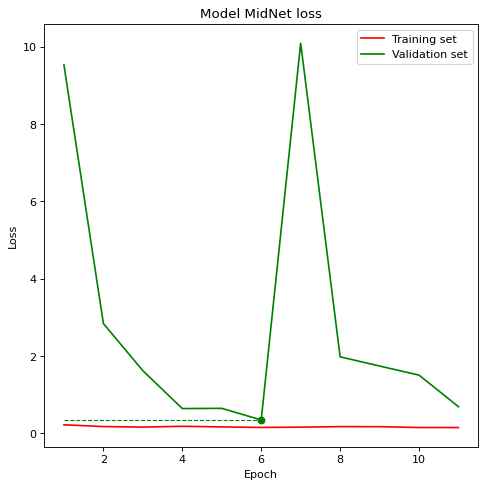

In [ ]:
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model MiDNet accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_acc_0, 'r', label='Training set')
plt.plot(epochs_0, val_acc_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_acc_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_acc_0), opt_val_acc_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model MidNet loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_loss_0, 'r', label='Training set')
plt.plot(epochs_0, val_loss_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_loss_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_loss_0), opt_val_loss_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
predictions_bi = model.predict(testX, verbose=0)
pred_bi = np.argmax(predictions_bi,axis=1)

In [ ]:
y_compare_bi = np.argmax(testY, axis =1)

In [ ]:
print(classification_report(y_compare_bi, pred_bi, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.6372    0.7784       113
           1     0.7338    1.0000    0.8464       113

    accuracy                         0.8186       226
   macro avg     0.8669    0.8186    0.8124       226
weighted avg     0.8669    0.8186    0.8124       226



In [ ]:
cm = confusion_matrix(y_compare_bi, pred_bi)

In [ ]:
cm_plot_labels = ['0','1']

Confusion matrix, without normalization
[[ 72  41]
 [  0 113]]


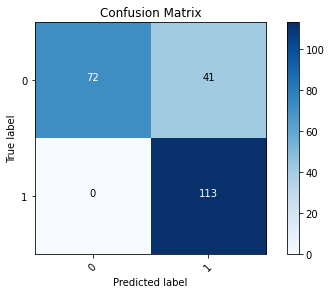

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
yhat4 = model.predict(testX, verbose=0)
pred4_ = np.argmax(yhat4,axis=1)
# calculate roc auc
y_comp4 = np.argmax(testY, axis =1)
roc_auc = roc_auc_score(y_comp4, pred4_)
print('No Skill ROC AUC %.4f' % roc_auc)

No Skill ROC AUC 0.8186


In [ ]:
fpr, tpr, thresholds = roc_curve(y_comp4, pred4_)

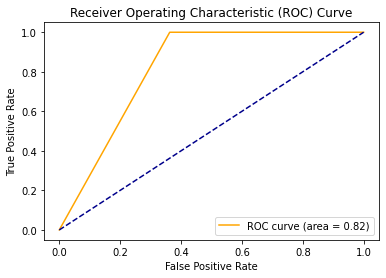

In [ ]:

plot_roc_curve(fpr, tpr)

# Testes Finais

In [ ]:
opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

NameError: ignored

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint ,TensorBoard,ReduceLROnPlateau, EarlyStopping

NAME = "MiDNet3.0-11"

tensorboard = TensorBoard(log_dir = "/content/drive/MyDrive/{}".format(NAME))


filepath = '/content/drive/MyDrive/MiDNet3.0-11_weights.h5' 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only = True, mode = 'max')
lr_reduce = ReduceLROnPlateau(monitor='accuracy', factor=0.1, min_delta=alpha, patience= 5, verbose= 1)

early_stop = EarlyStopping(monitor='val_accuracy',
min_delta=0.001,
patience=5,
mode='min',
verbose=1)

callbacks = [checkpoint, lr_reduce,tensorboard]

In [ ]:

opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
model.load_weights('/content/drive/MyDrive/MiDNet3.0-11_weights.h5')

In [ ]:
history_3 = model.fit(trainX, trainY, steps_per_epoch=len(trainX)//batch_size, validation_data=(testX, testY), validation_steps= len(testX)//batch_size,callbacks=callbacks, epochs = epoch)


Epoch 1/80
23/23 [==============================] - ETA: 0s - loss: 1.1363 - accuracy: 0.9254
Epoch 00001: val_accuracy did not improve from 0.70244
23/23 [==============================] - 3s 119ms/step - loss: 1.1363 - accuracy: 0.9254 - val_loss: 1.6732 - val_accuracy: 0.6927 - lr: 1.0000e-21
Epoch 2/80
23/23 [==============================] - ETA: 0s - loss: 1.1426 - accuracy: 0.9261
Epoch 00002: val_accuracy did not improve from 0.70244
23/23 [==============================] - 2s 94ms/step - loss: 1.1426 - accuracy: 0.9261 - val_loss: 1.6718 - val_accuracy: 0.6959 - lr: 1.0000e-21
Epoch 3/80
23/23 [==============================] - ETA: 0s - loss: 1.1322 - accuracy: 0.9317
Epoch 00003: val_accuracy did not improve from 0.70244
23/23 [==============================] - 2s 96ms/step - loss: 1.1322 - accuracy: 0.9317 - val_loss: 1.6737 - val_accuracy: 0.6992 - lr: 1.0000e-21
Epoch 4/80
23/23 [==============================] - ETA: 0s - loss: 1.1465 - accuracy: 0.9247
Epoch 00004: val_

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam, Adagrad

In [ ]:
opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2 = 0.999)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
history_3 = model.fit(trainX, trainY, steps_per_epoch=len(trainX)//batch_size, validation_data=(testX, testY), validation_steps= len(testX)//batch_size,callbacks=callbacks, epochs = epoch)


Epoch 1/80
23/23 [==============================] - ETA: 0s - loss: 2.1349 - accuracy: 0.6049
Epoch 00001: val_loss improved from -inf to 2.01544, saving model to /content/drive/MyDrive/MiDNet3.0-7_weights.h5
23/23 [==============================] - 16s 258ms/step - loss: 2.1349 - accuracy: 0.6049 - val_loss: 2.0154 - val_accuracy: 0.6423 - lr: 0.0010
Epoch 2/80
23/23 [==============================] - ETA: 0s - loss: 1.7271 - accuracy: 0.6690
Epoch 00002: val_loss did not improve from 2.01544
23/23 [==============================] - 2s 97ms/step - loss: 1.7271 - accuracy: 0.6690 - val_loss: 1.6370 - val_accuracy: 0.6423 - lr: 0.0010
Epoch 3/80
23/23 [==============================] - ETA: 0s - loss: 1.4070 - accuracy: 0.6815
Epoch 00003: val_loss did not improve from 2.01544
23/23 [==============================] - 2s 97ms/step - loss: 1.4070 - accuracy: 0.6815 - val_loss: 1.4829 - val_accuracy: 0.6423 - lr: 0.0010
Epoch 4/80
23/23 [==============================] - ETA: 0s - loss: 1.

In [ ]:

opt = Adagrad(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='a', metrics=['accuracy'])

In [ ]:
history_3 = model.fit(trainX, trainY, steps_per_epoch=len(trainX)//batch_size, validation_data=(testX, testY), validation_steps= len(testX)//batch_size,callbacks=callbacks, epochs = epoch)


Epoch 1/80
22/23 [===========================>..] - ETA: 0s - loss: 1.4376 - accuracy: 0.5101
Epoch 00001: val_accuracy did not improve from 0.70244
23/23 [==============================] - 4s 107ms/step - loss: 1.4377 - accuracy: 0.5094 - val_loss: 1.3470 - val_accuracy: 0.3577 - lr: 0.0010
Epoch 2/80
22/23 [===========================>..] - ETA: 0s - loss: 1.4165 - accuracy: 0.5152
Epoch 00002: val_accuracy did not improve from 0.70244
23/23 [==============================] - 2s 74ms/step - loss: 1.4151 - accuracy: 0.5185 - val_loss: 1.3223 - val_accuracy: 0.6423 - lr: 0.0010
Epoch 3/80
22/23 [===========================>..] - ETA: 0s - loss: 1.3753 - accuracy: 0.5671
Epoch 00003: val_accuracy did not improve from 0.70244
23/23 [==============================] - 2s 74ms/step - loss: 1.3761 - accuracy: 0.5659 - val_loss: 1.3066 - val_accuracy: 0.6423 - lr: 0.0010
Epoch 4/80
22/23 [===========================>..] - ETA: 0s - loss: 1.3648 - accuracy: 0.5714
Epoch 00004: val_accuracy did

In [ ]:
model.load_weights('/content/drive/MyDrive/MiDNet3.0-10_weights.h5')

In [ ]:
_, acc = model.evaluate( testX,testY, verbose=0)
print('> %.4f' % (acc * 100.0))

> 73.4959


In [ ]:
_, acc = model.evaluate( testX,testY, verbose=0)

In [ ]:
print('> %.4f' % (acc * 100.0))

> 74.8333


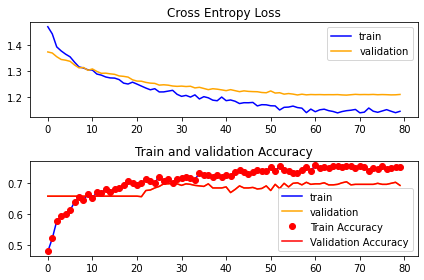

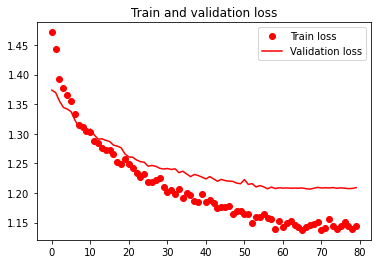

In [ ]:
import matplotlib.pyplot as plt

ax1 = plt.subplot(211)
plt.title('Cross Entropy Loss')
ax1.plot(history_3.history['loss'], color='blue', label='train')
ax1.plot(history_3.history['val_loss'], color='orange', label='validation')
ax1.legend()
    # plot accuracy
ax2 = plt.subplot(212)
plt.title('Classification Accuracy')
ax2.plot(history_3.history['accuracy'], color='blue', label='train')
ax2.plot(history_3.history['val_accuracy'], color='orange', label='validation')
ax2.legend()
plt.tight_layout()

# Commented out IPython magic to ensure Python compatibility.
import matplotlib.pyplot as plt
# %matplotlib inline

accuracy = history_3.history['accuracy']
val_accuracy = history_3.history['val_accuracy']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'ro', label='Train Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Train and validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'ro', label='Train loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Train and validation loss')
plt.legend()
plt.show()

tra_loss_0 = history_3.history['loss']
tra_acc_0 = history_3.history['accuracy']
val_loss_0 = history_3.history['val_loss']
val_acc_0 = history_3.history['val_accuracy']

epochs_0 = range(1, len(tra_acc_0)+1)
end_epoch_0 = len(tra_acc_0)

opt_epoch_0 = val_loss_0.index(min(val_loss_0)) + 1

end_val_loss_0 = val_loss_0[-1]
end_val_acc_0 = val_acc_0[-1]
opt_val_loss_0 = val_loss_0[opt_epoch_0-1]
opt_val_acc_0 = val_acc_0[opt_epoch_0-1]


In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [ ]:
predictions_bi = model.predict(testX, verbose=0)
pred_bi = np.argmax(predictions_bi,axis=1)

In [ ]:
y_compare_bi = np.argmax(testY, axis =1)

In [ ]:
print(classification_report(y_compare_bi, pred_bi, digits=4))

              precision    recall  f1-score   support

           0     0.6875    0.4829    0.5673       205
           1     0.7675    0.8861    0.8226       395

    accuracy                         0.7483       600
   macro avg     0.7275    0.6845    0.6949       600
weighted avg     0.7402    0.7483    0.7354       600



In [ ]:


# Re-evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

# Benigno e Maligno


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint ,TensorBoard,ReduceLROnPlateau, EarlyStopping

NAME = "MiDNet3.0-5"

tensorboard = TensorBoard(log_dir = "/content/drive/MyDrive/{}".format(NAME))


filepath = '/content/drive/MyDrive/MiDNet3.0-5_weights.h5' 
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only = True, mode = 'max')
lr_reduce = ReduceLROnPlateau(monitor='loss', factor=0.1, min_delta=alpha, patience= 5, verbose= 1)

early_stop = EarlyStopping(monitor='val_loss',
min_delta=0.001,
patience=5,
mode='min',
verbose=1)

callbacks = [checkpoint ,lr_reduce,tensorboard]